In [ ]:
# in this file we'll be
# importing the HRs
# Making the groups and finding 3 intersections
# doing a pad interpolation to be simple
# adding it to a combined Df 

In [1]:
import os
import sys
def getRepoPath():
    cwd = os.getcwd()
    delimiter = "\\" if "\\" in cwd else "/"
    repoPath = delimiter.join(cwd.split(delimiter)[:cwd.split(delimiter).index("dataImport")]) + delimiter
    return repoPath
repoPath = getRepoPath()
sys.path.append(repoPath + 'dataImport/')
from utils import workingDataPath, getWorkingHRDfParquet, getHRGroups, calcIntersectionOfMultipleGroups, getHRsForTimePeriods, secBySecHRGraph
import pandas as pd
from datetime import date, time, timedelta

/home/chowder/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
appleHRDf = getWorkingHRDfParquet('apple')
polarHRDf = getWorkingHRDfParquet('polar')
fitbitHRDf = getWorkingHRDfParquet('fitbit')
appleGroups = getHRGroups(appleHRDf, 20)
polarGroups = getHRGroups(polarHRDf, 20)
fitbitGroups = getHRGroups(fitbitHRDf, 20)
all_intersections = calcIntersectionOfMultipleGroups([appleGroups, fitbitGroups, polarGroups])
all_intersections_lengths = [g[1] - g[0] for g in all_intersections]
maxLenIntersectIndex = all_intersections_lengths.index(max(all_intersections_lengths))

In [14]:
def getHRDfFroGroups(HRDf, groups):
    if len(groups) == 0: return []
    HRForGroupsDf = getHRsForTimePeriods(pd.DataFrame([groups[0]], columns = ['startDate', 'endDate']), HRDf)
    for groupI in range(1, len(groups)):
        HRForGroupsDf = pd.concat([HRForGroupsDf, getHRsForTimePeriods(pd.DataFrame([groups[groupI]], columns = ['startDate', 'endDate']), HRDf)])
    return HRForGroupsDf

# interpolate, then intersect
def getInterpGroupsHRDf(HRDfs, groups, deviceNames, interpType = 'linear'):
    combinedDf = getHRDfFroGroups(HRDfs[0], groups)
    combinedDf['value_' + deviceNames[0]] = combinedDf.pop('value')
    combinedDf = combinedDf.resample('1s').asfreq().interpolate(method=interpType).round()

    for HRDfI in range(1, len(HRDfs)):
        otherDf = getHRDfFroGroups(HRDfs[HRDfI], groups)
        otherDf = otherDf.resample('1s').asfreq().interpolate(method=interpType).round()
        combinedDf = combinedDf.join(otherDf, rsuffix=deviceNames[HRDfI], how='inner')
        combinedDf['value_' + deviceNames[HRDfI]] = combinedDf.pop('value')
    
    return combinedDf

In [15]:
combinedInterpedHRs = getInterpGroupsHRDf([polarHRDf, appleHRDf, fitbitHRDf], all_intersections, ['polar', 'apple', 'fitbit'])

In [18]:
combinedInterpedHRs

,value_polar,value_apple,value_fitbit
sampleDT,,,
2024-03-10 04:15:59+00:00,73.0,105.0,113.0
2024-03-10 04:16:00+00:00,73.0,105.0,113.0
2024-03-10 04:16:01+00:00,73.0,105.0,114.0
2024-03-10 04:16:02+00:00,73.0,105.0,114.0
2024-03-10 04:16:03+00:00,73.0,105.0,115.0
...,...,...,...
2024-09-17 18:04:53+00:00,88.0,88.0,77.0
2024-09-17 18:04:54+00:00,87.0,88.0,77.0
2024-09-17 18:04:55+00:00,87.0,89.0,76.0


In [60]:
import pandas as pd
import numpy as np

# Function to apply Kalman filter and quantify noise in the less accurate sensors
def kalman_filter_estimate_noise(df_accurate, df_inaccurate1, df_inaccurate2):
    # Ensure all dataframes are aligned on the same timestamp index
    combined_df = pd.concat([df_accurate['value'], df_inaccurate1['value'], df_inaccurate2['value']], axis=1, 
                            keys=['hr_accurate', 'hr_inaccurate1', 'hr_inaccurate2']).dropna()

    # Kalman filter initialization
    combined_estimate = []  # To store the combined heart rate estimates
    noise_estimates1 = []   # To store the estimated noise for sensor 1
    noise_estimates2 = []   # To store the estimated noise for sensor 2
    
    # Initial values
    current_estimate = df_accurate['value'].iloc[0]  # Start with the first accurate measurement
    estimate_uncertainty = 1.0  # Initial uncertainty of the estimate (P)
    process_variance = 10  # Process variance (Q) - small assuming smooth changes in heart rate

    # Initial measurement variances for the inaccurate sensors
    measurement_variance1 = 1.0  # Will be updated based on the error of sensor 1
    measurement_variance2 = 1.0  # Will be updated based on the error of sensor 2

    # Loop through the timestamps and apply the Kalman filter
    for timestamp, row in combined_df.iterrows():
        # Accurate measurement
        hr_accurate = row['hr_accurate']
        
        # Inaccurate sensor measurements
        hr_inaccurate1 = row['hr_inaccurate1']
        hr_inaccurate2 = row['hr_inaccurate2']
        
        # Prediction step
        prediction = current_estimate  # No change in the prediction step (identity state transition)
        estimate_uncertainty += process_variance  # Increase uncertainty due to process variance

        # Update measurement variances (noise estimation) for the inaccurate sensors
        # Based on the difference from the accurate sensor
        error1 = hr_inaccurate1 - hr_accurate
        error2 = hr_inaccurate2 - hr_accurate

        # Dynamically update the measurement variances for the inaccurate sensors
        measurement_variance1 = 0.9 * measurement_variance1 + 0.1 * (error1 ** 2)
        measurement_variance2 = 0.9 * measurement_variance2 + 0.1 * (error2 ** 2)

        # Measurement update step for Sensor 1 (Correction)
        kalman_gain1 = estimate_uncertainty / (estimate_uncertainty + measurement_variance1)
        current_estimate = prediction + kalman_gain1 * (hr_inaccurate1 - prediction)
        estimate_uncertainty = (1 - kalman_gain1) * estimate_uncertainty

        # Measurement update step for Sensor 2 (Correction)
        kalman_gain2 = estimate_uncertainty / (estimate_uncertainty + measurement_variance2)
        current_estimate = prediction + kalman_gain2 * (hr_inaccurate2 - prediction)
        estimate_uncertainty = (1 - kalman_gain2) * estimate_uncertainty

        # Store the combined estimate and noise estimates
        combined_estimate.append(current_estimate)
        noise_estimates1.append(measurement_variance1)
        noise_estimates2.append(measurement_variance2)

    # Return the combined heart rate estimates and noise estimates as Pandas DataFrame
    combined_df['combined_hr'] = combined_estimate
    combined_df['noise_inaccurate1'] = noise_estimates1
    combined_df['noise_inaccurate2'] = noise_estimates2
    
    return combined_df[['combined_hr', 'noise_inaccurate1', 'noise_inaccurate2']]

# Sample usage:
# Assuming df_accurate, df_inaccurate1, df_inaccurate2 are your three heart rate dataframes
# df_accurate has values from the accurate sensor, and df_inaccurate1/df_inaccurate2 have values from less accurate sensors

# df_accurate = pd.DataFrame([...])  # Accurate sensor heart rate
# df_inaccurate1 = pd.DataFrame([...])  # Inaccurate sensor 1 heart rate
# df_inaccurate2 = pd.DataFrame([...])  # Inaccurate sensor 2 heart rate

# Apply the Kalman filter and quantify noise
# combined_heart_rate_df = kalman_filter_estimate_noise(df_accurate, df_inaccurate1, df_inaccurate2)

# Print the combined result and noise estimates
# print(combined_heart_rate_df)


In [61]:
groupNum = 69

separatePolar = pd.DataFrame(combinedInterpedHRs['value_polar'])
separatePolar['value'] = separatePolar.pop('value_polar')
separatePolar = getHRsForTimePeriods(pd.DataFrame([all_intersections[groupNum]], columns = ['startDate', 'endDate']), separatePolar)
separateApple = pd.DataFrame(combinedInterpedHRs['value_apple'])
separateApple['value'] = separateApple.pop('value_apple')
separateApple = getHRsForTimePeriods(pd.DataFrame([all_intersections[groupNum]], columns = ['startDate', 'endDate']), separateApple)
separateFitbit = pd.DataFrame(combinedInterpedHRs['value_fitbit'])
separateFitbit['value'] = separateFitbit.pop('value_fitbit')
separateFitbit = getHRsForTimePeriods(pd.DataFrame([all_intersections[groupNum]], columns = ['startDate', 'endDate']), separateFitbit)


kalmanOutputs = kalman_filter_estimate_noise(separatePolar, separateApple, separateFitbit)
kalmanVals = pd.DataFrame(kalmanOutputs.combined_hr.round())
kalmanVals['value'] = kalmanVals.pop('combined_hr').round()
kalmanOutputs

,combined_hr,noise_inaccurate1,noise_inaccurate2
sampleDT,,,
2024-09-17 08:29:36+00:00,76.228048,3.400000,1.800000
2024-09-17 08:29:37+00:00,75.644427,3.960000,3.220000
2024-09-17 08:29:38+00:00,75.398249,3.664000,4.498000
2024-09-17 08:29:39+00:00,74.953571,3.397600,5.648200
2024-09-17 08:29:40+00:00,74.432927,3.057840,6.683380
...,...,...,...
2024-09-17 17:11:22+00:00,66.236653,1.464994,1.980464
2024-09-17 17:11:23+00:00,67.792516,2.918494,1.782417
2024-09-17 17:11:24+00:00,68.604384,5.126645,1.704176


In [47]:
kalmanVals

,value
sampleDT,
2024-09-17 08:29:36+00:00,77.0
2024-09-17 08:29:37+00:00,77.0
2024-09-17 08:29:38+00:00,77.0
2024-09-17 08:29:39+00:00,77.0
2024-09-17 08:29:40+00:00,76.0
...,...
2024-09-17 17:11:22+00:00,63.0
2024-09-17 17:11:23+00:00,63.0
2024-09-17 17:11:24+00:00,64.0


In [32]:
separatePolar

,value
sampleDT,
2024-09-17 08:29:36+00:00,78.0
2024-09-17 08:29:37+00:00,79.0
2024-09-17 08:29:38+00:00,79.0
2024-09-17 08:29:39+00:00,78.0
2024-09-17 08:29:40+00:00,77.0
...,...
2024-09-17 17:11:22+00:00,68.0
2024-09-17 17:11:23+00:00,69.0
2024-09-17 17:11:24+00:00,70.0


In [30]:
kalmanOutputs.noise_inaccurate1.mean()

2.119062845609361

In [31]:
kalmanOutputs.noise_inaccurate2.mean()

16.752169095825696

In [34]:
all_intersections[groupNum]

[Timestamp('2024-09-17 01:29:36-0700', tz='pytz.FixedOffset(-420)'),
 Timestamp('2024-09-17 10:11:26-0700', tz='pytz.FixedOffset(-420)')]

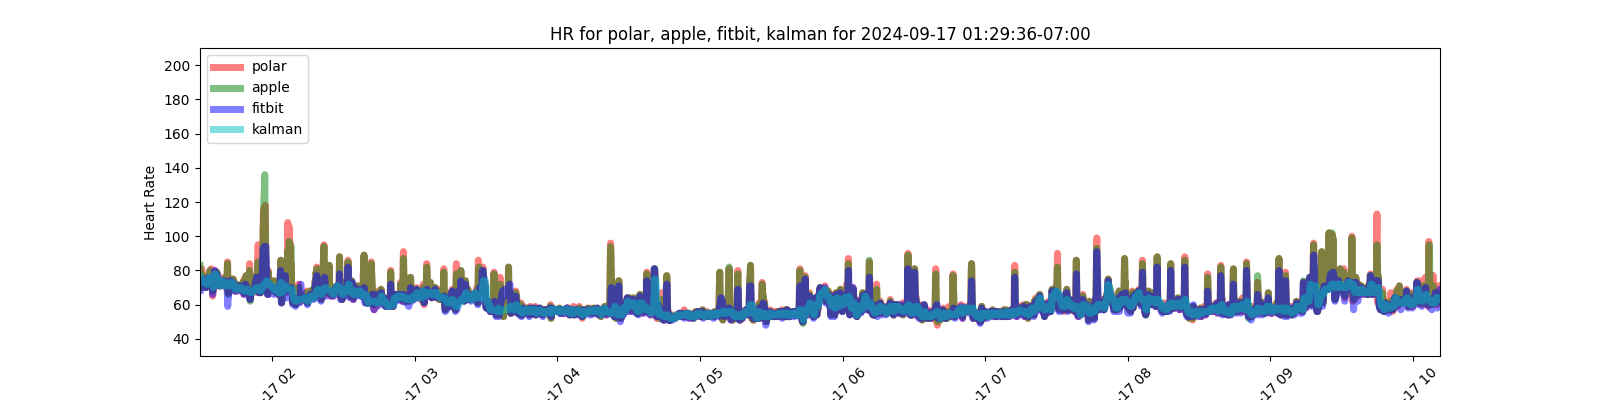

In [49]:
%matplotlib widget
#gain 0.01
secBySecHRGraph([separatePolar, separateApple, separateFitbit, kalmanVals], all_intersections[groupNum], ['polar', 'apple', 'fitbit', 'kalman'], False)

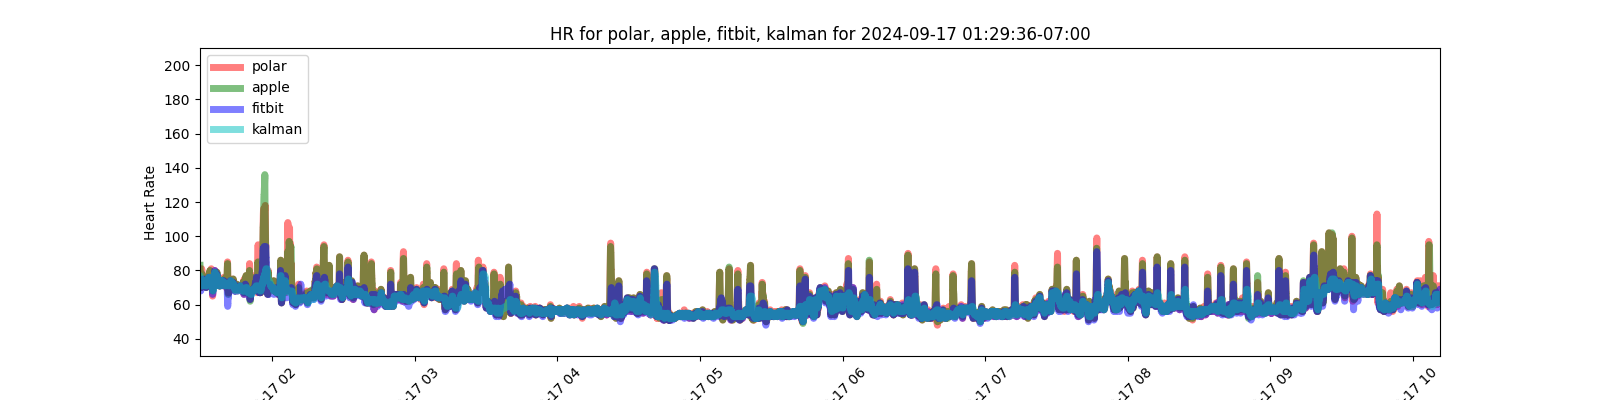

In [53]:
#gain 0.1
secBySecHRGraph([separatePolar, separateApple, separateFitbit, kalmanVals], all_intersections[groupNum], ['polar', 'apple', 'fitbit', 'kalman'], False)

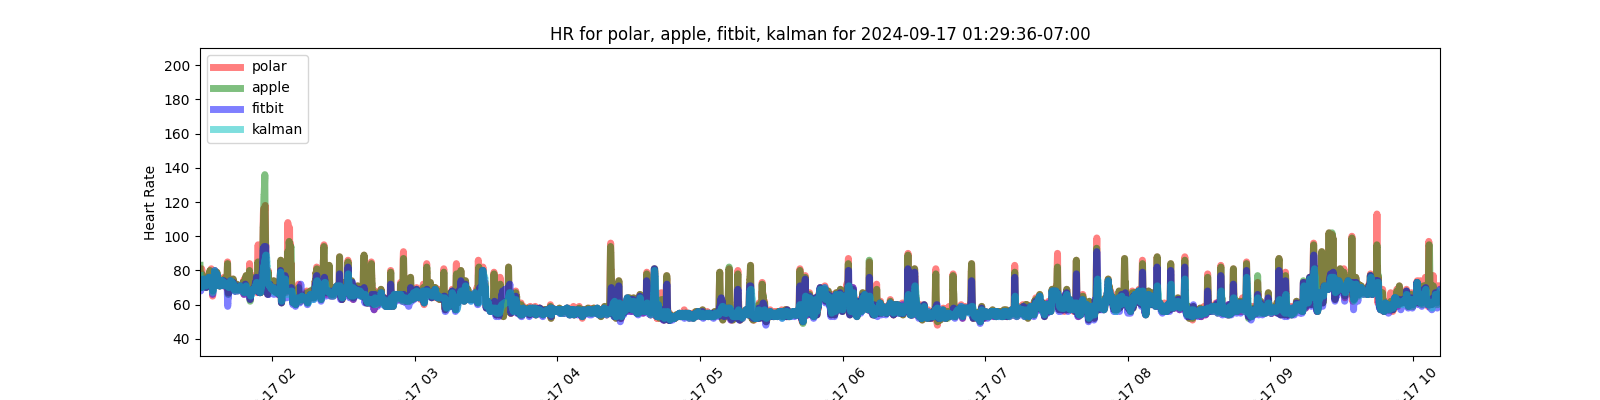

In [56]:
#gain 0.8
secBySecHRGraph([separatePolar, separateApple, separateFitbit, kalmanVals], all_intersections[groupNum], ['polar', 'apple', 'fitbit', 'kalman'], False)

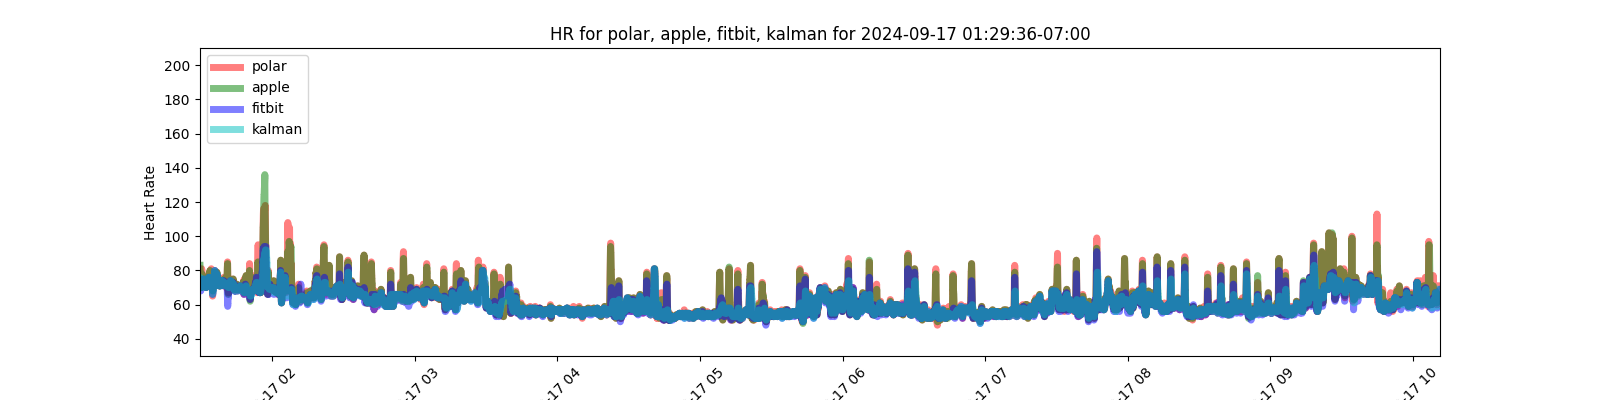

In [59]:
#gain 3
secBySecHRGraph([separatePolar, separateApple, separateFitbit, kalmanVals], all_intersections[groupNum], ['polar', 'apple', 'fitbit', 'kalman'], False)

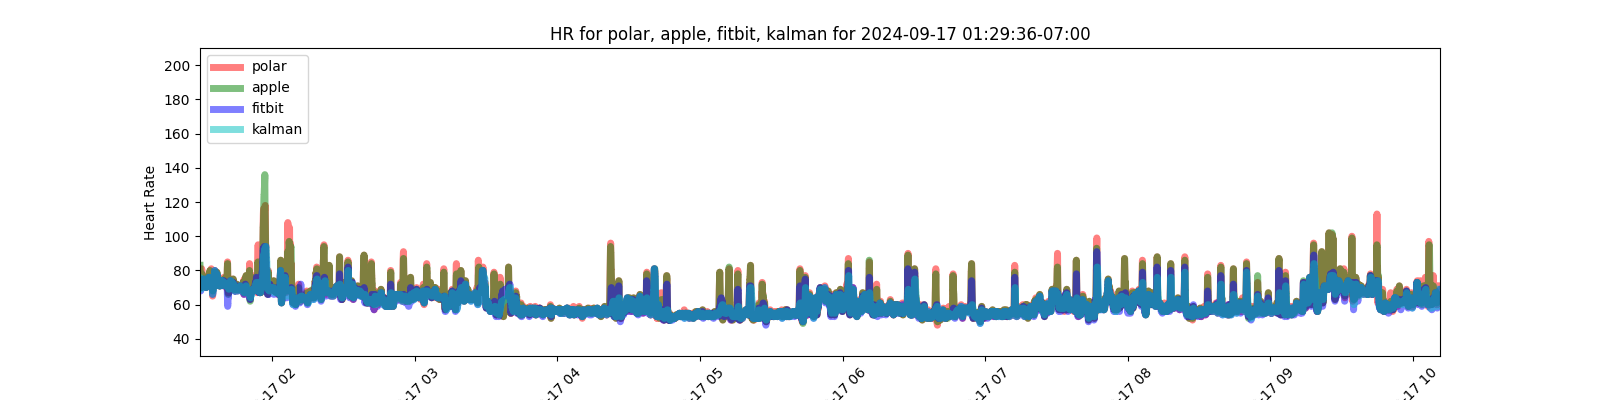

In [62]:
#gain 10
secBySecHRGraph([separatePolar, separateApple, separateFitbit, kalmanVals], all_intersections[groupNum], ['polar', 'apple', 'fitbit', 'kalman'], False)